In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
rates_df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
rates_df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


# Part 1 : Data Preprocessing

In [4]:
rates_df.shape

(7588, 2)

In [5]:
rates_df.dtypes

,0
date,object
Ex_rate,float64


# Convert the date column to datetime format.

In [6]:
rates_df['date']=pd.to_datetime(rates_df['date'],format='%d-%m-%Y %H:%M')
rates_df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [7]:
# Set 'date' as the index for time series operations
rates_df.set_index('date', inplace=True)

In [8]:
rates_df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


# Initial Exploration

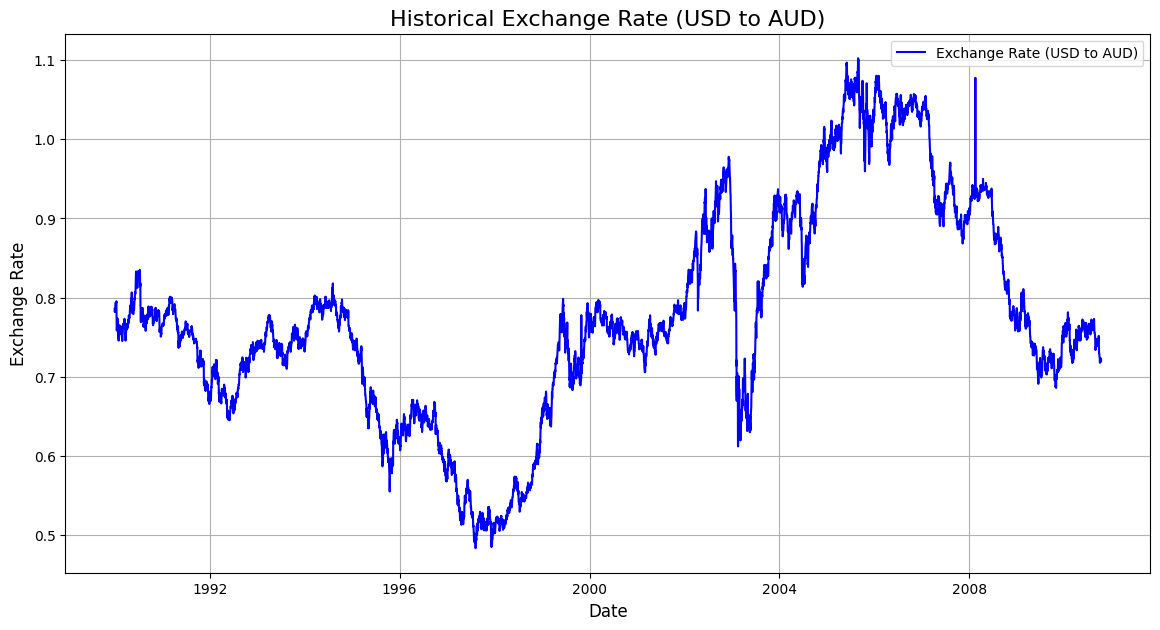

In [9]:
# Initial Exploration: Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(rates_df['Ex_rate'], label='Exchange Rate (USD to AUD)', color='blue')
plt.title('Historical Exchange Rate (USD to AUD)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.legend()
plt.grid()
plt.show()

- The plot provides a visualization of the historical exchange rate (USD to AUD) over time:

- Trends: There appears to be significant variability over the years, with some long-term upward and downward movements.

- Seasonality: Further analysis may be required to confirm seasonal patterns.

- Anomalies: Sudden spikes or dips in the exchange rate are visible, which may need attention during preprocessing.

# DATA PREPROCESSING

In [10]:
# check missing values
rates_df.isnull().sum()

,0
Ex_rate,0


In [11]:
#  Summary statistics for detecting anomalies

summary_stats = rates_df['Ex_rate'].describe()
summary_stats

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


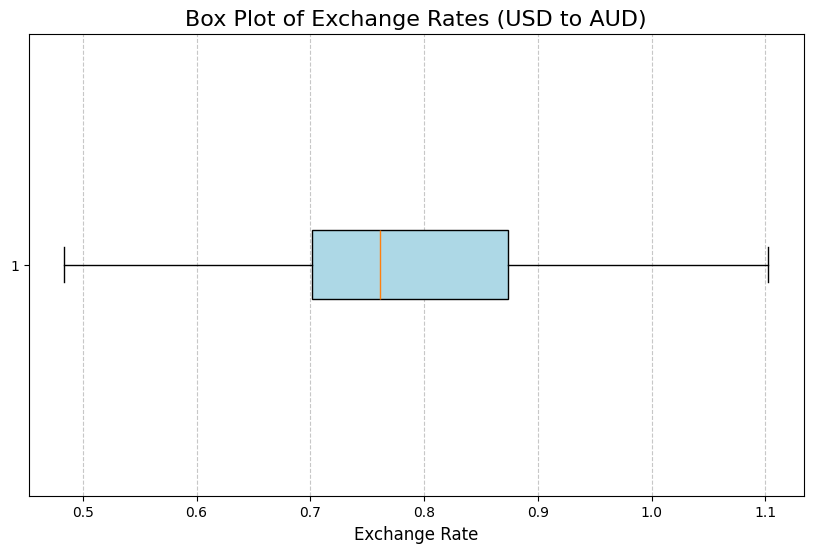

In [12]:
# Box plot to visualize potential outliers

plt.figure(figsize=(10, 6))
plt.boxplot(rates_df['Ex_rate'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Exchange Rates (USD to AUD)', fontsize=16)
plt.xlabel('Exchange Rate', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

- Decompose the time series to understand trends, seasonality, and residuals, which will help in model preparation.

- Seasonal decomposition of time series is a statistical method that breaks down a time series into three components: trend, seasonal, and residual.
- It's used to analyze time series that are affected by cyclical patterns.

In [14]:
#Perform seasonal decomposition

decomposition = seasonal_decompose(rates_df['Ex_rate'], model='additive', period=365)
decomposition

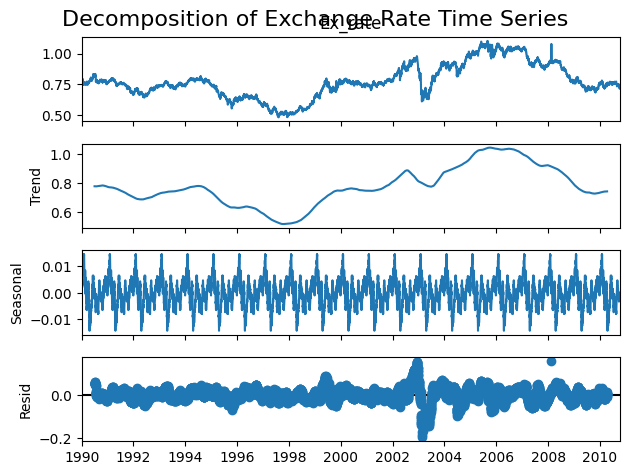

<Figure size 640x480 with 0 Axes>

In [15]:
# plot the decomposed components

decomposition.plot()
plt.suptitle('Decomposition of Exchange Rate Time Series', fontsize=16)
plt.show()
plt.tight_layout()

# Part 2 : Model Building - ARIMA

- ACF and PACF Plots for ARIMA parameter selection.

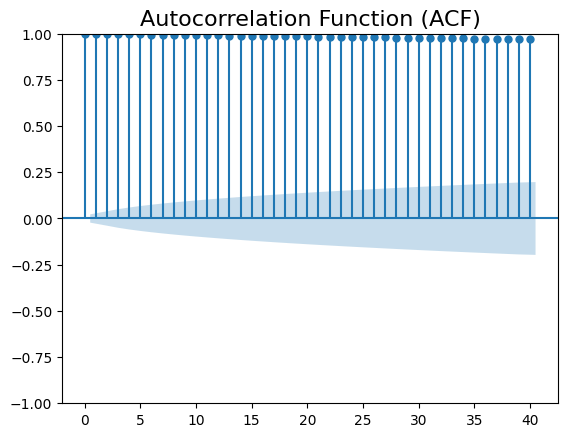

<Figure size 640x480 with 0 Axes>

In [16]:
plot_acf(rates_df['Ex_rate'], lags=40)
plt.title('Autocorrelation Function (ACF)', fontsize=16)
plt.show()
plt.tight_layout()

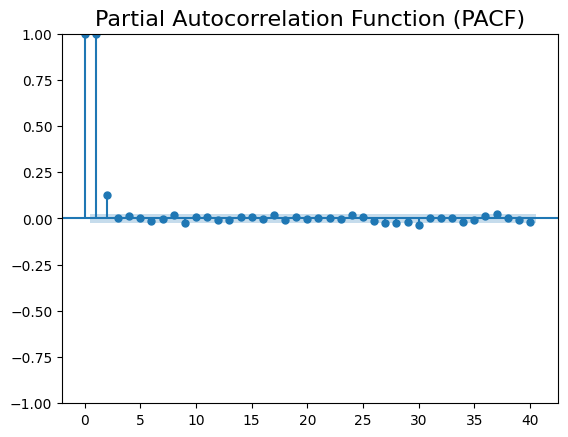

In [17]:
plot_pacf(rates_df['Ex_rate'], lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)
plt.show()

# Fit the ARIMA Model

In [18]:
p, d, q = 2, 1, 2  # example: p=2, d=1, q=2 based on ACF/PACF analysis.
arima_model = ARIMA(rates_df['Ex_rate'], order=(p, d, q))

In [19]:
arima_results=arima_model.fit()

In [20]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 2)   Log Likelihood               28055.068
Date:                Mon, 03 Feb 2025   AIC                         -56100.135
Time:                        14:28:46   BIC                         -56065.464
Sample:                    01-01-1990   HQIC                        -56088.236
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1151      0.585     -0.197      0.844      -1.261       1.031
ar.L2          0.1132      0.088      1.293      0.196      -0.058       0.285
ma.L1         -0.0163      0.584     -0.028      0.978      -1.162       1.129
ma.L2         -0.1135      0.052     -2.172      0.030      -0.216      -0.011
sigma2      3.594e-05   1.01e-07    355.944      0.000    3.57e-05    3.61e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2863303.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Diagnostics of ARIMA model

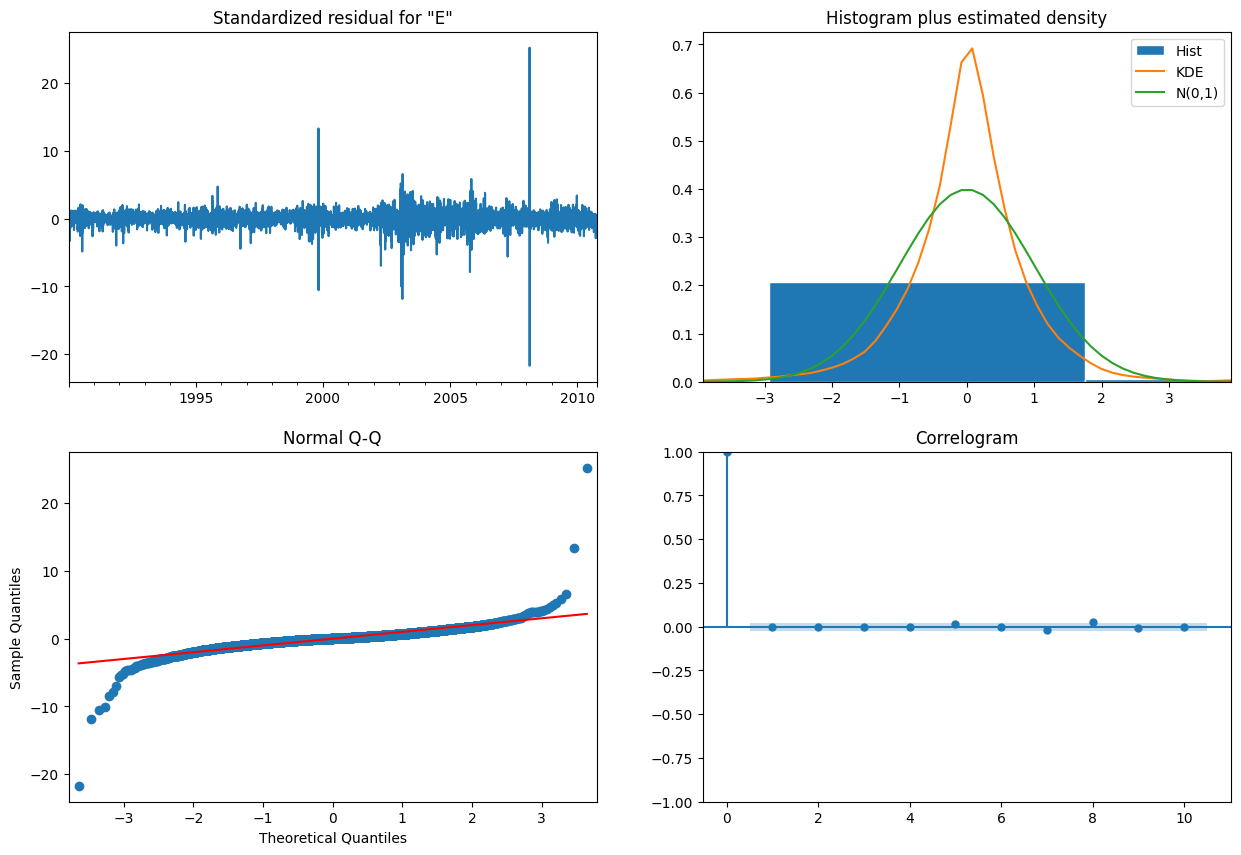

In [21]:
arima_results.plot_diagnostics(figsize=(15, 10))
plt.show()

# Forecasting with ARIMA model.

In [22]:
forecast_steps = 30  # Forecast the next 30 days
forecast = arima_results.forecast(steps=forecast_steps)

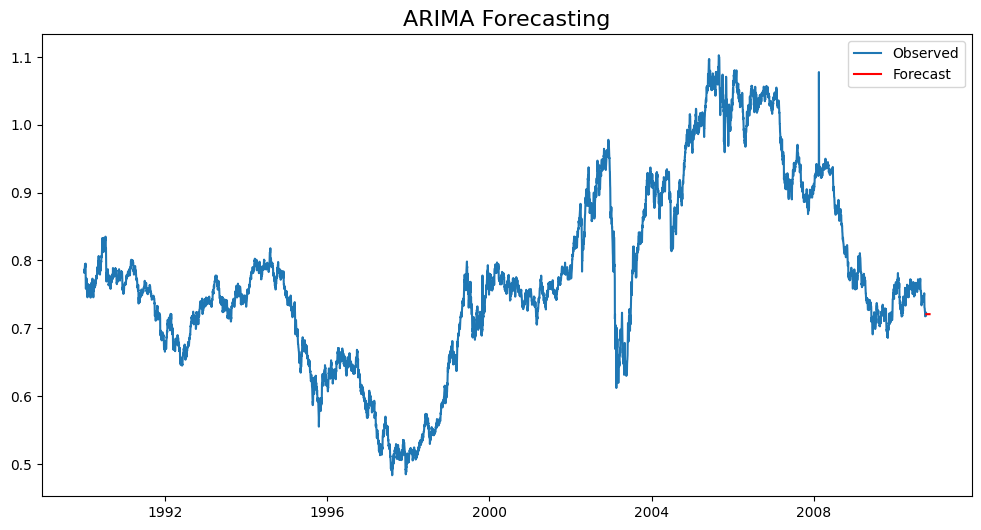

In [23]:
# plot the forcast

plt.figure(figsize=(12, 6))
plt.plot(rates_df['Ex_rate'], label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.title('ARIMA Forecasting', fontsize=16)
plt.legend()
plt.show()

# Part 3 : Model Building : Exponential Smoothing

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
# Exponential Smoothing: Holt-Winters Model

hw_model = ExponentialSmoothing(rates_df['Ex_rate'], seasonal='add', seasonal_periods=365)

In [26]:
# fit the model
hw_results = hw_model.fit()

In [27]:
# print optimized parameters
print(hw_results.params)

{'smoothing_level': 0.8731360671671965, 'smoothing_trend': nan, 'smoothing_seasonal': 0.0008041703020695004, 'damping_trend': nan, 'initial_level': 0.7817512146588802, 'initial_trend': nan, 'initial_seasons': array([ 3.34773936e-03,  4.48783954e-03,  2.12800514e-03,  3.69505363e-03,
        4.31519363e-03,  4.55995171e-03,  3.98839780e-03,  5.19013261e-03,
        4.65295938e-03,  6.33058524e-03,  7.21387694e-03,  8.33819486e-03,
        9.28231833e-03,  1.06832157e-02,  9.32497491e-03,  9.34082964e-03,
        8.84524972e-03,  7.08819761e-03,  8.81211118e-03,  8.78012845e-03,
        9.44201699e-03,  1.00060569e-02,  9.05204495e-03,  8.68426124e-03,
        7.25850946e-03,  7.41939549e-03,  9.55673101e-03,  1.10038178e-02,
        9.74379006e-03,  1.13663486e-02,  1.23620497e-02,  1.34069926e-02,
        1.30666951e-02,  1.29534663e-02,  1.35152759e-02,  1.34252415e-02,
        1.15366835e-02,  9.25819808e-03,  8.48013779e-03,  6.06510579e-03,
        6.92367862e-03,  3.64702959e-03, 

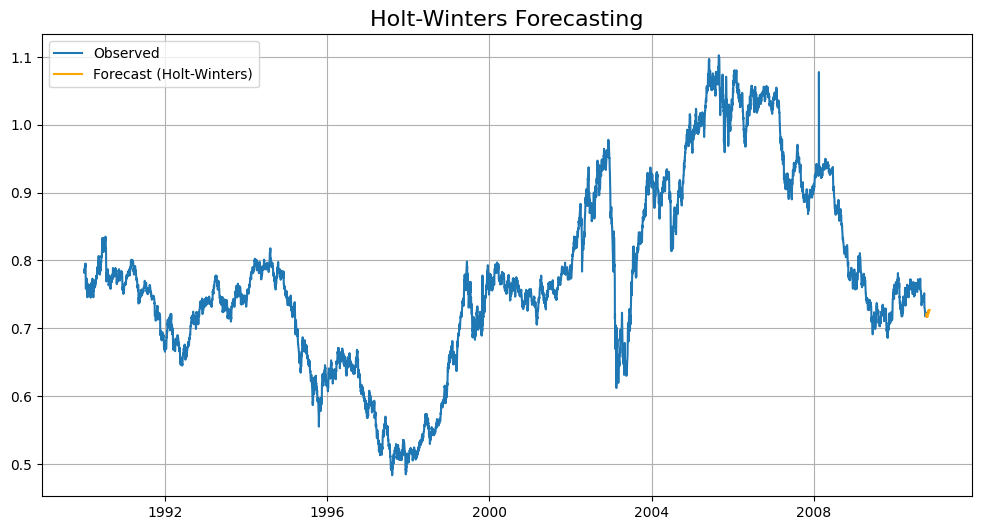

In [28]:
# Forecasting with Holt-Winters
forecast_steps=30
hw_forecast = hw_results.forecast(forecast_steps) # forcast for next 30 days

plt.figure(figsize=(12, 6))
plt.plot(rates_df['Ex_rate'], label='Observed')
plt.plot(hw_forecast, label='Forecast (Holt-Winters)', color='orange')
plt.title('Holt-Winters Forecasting', fontsize=16)
plt.legend()
plt.grid()
plt.show()

# Grid Search and AIC to find Optimal Parameters

In [29]:
# Define parameter ranges for alpha, beta, gamma
alpha_range = np.linspace(0.1, 1.0, 10)  # Example: [0.1, 0.2, ..., 1.0]
beta_range = np.linspace(0.1, 1.0, 10)
gamma_range = np.linspace(0.1, 1.0, 10)

In [30]:
from itertools import product   # imported product

In [32]:
# ... (other code remains the same)

# Define parameter ranges for alpha, beta, gamma (adjust as needed)
alpha_range = np.linspace(0.1, 1.0, 5)
beta_range = np.linspace(0.1, 1.0, 5)
gamma_range = np.linspace(0.1, 1.0, 5)

# Initialize variables to store the best parameters and corresponding AIC
best_aic = float('inf')
best_params = None
best_model = None

# Perform grid search
for alpha, beta, gamma in product(alpha_range, beta_range, gamma_range):
    try:
        # Fit the model with current parameters
        model = ExponentialSmoothing(
            rates_df['Ex_rate'],
            trend='add',  # Additive trend
            seasonal='add',  # Additive seasonality
            seasonal_periods=12  # Reduced seasonal periods
        ).fit(optimized=True, use_brute=True) #Optimized search for parameters

        # Evaluate AIC
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (alpha, beta, gamma)
            best_model = model
    except Exception as e:
        continue

# Print the best parameters and AIC
print(f"Best Parameters (alpha, beta, gamma): {best_params}")
print(f"Best AIC: {best_aic}")

Best Parameters (alpha, beta, gamma): (0.1, 0.1, 0.1)
Best AIC: -77624.57383861551


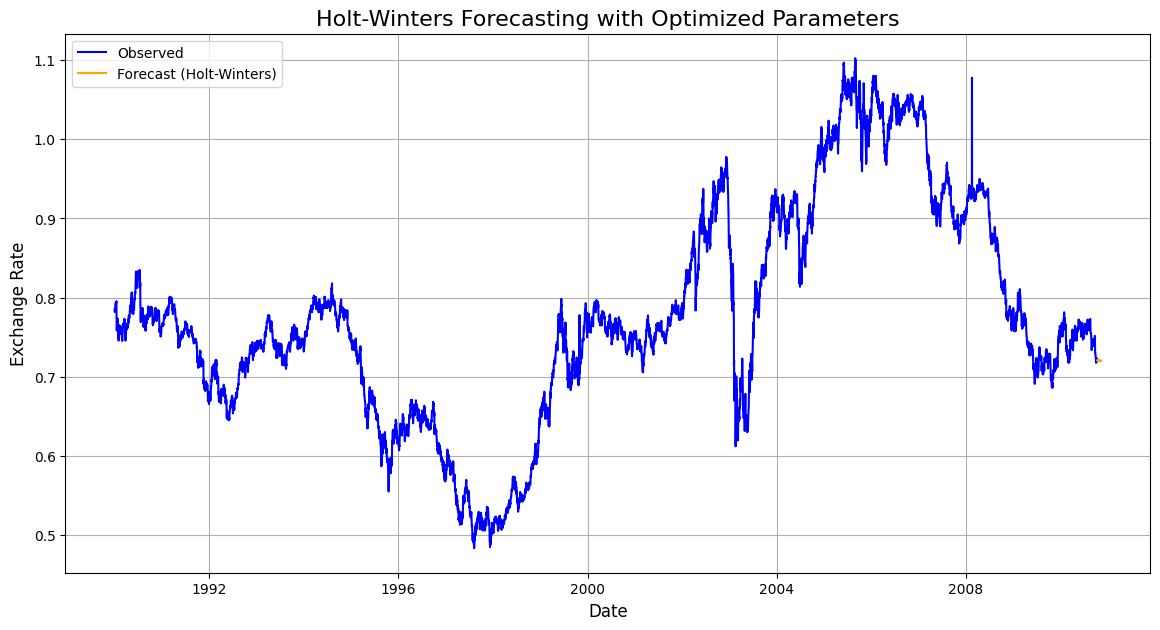

In [33]:
# Forecast using the best model
forecast_steps = 30
forecast = best_model.forecast(steps=forecast_steps)

# Plot observed and forecasted values
plt.figure(figsize=(14, 7))
plt.plot(rates_df['Ex_rate'], label='Observed', color='blue')
plt.plot(forecast, label='Forecast (Holt-Winters)', color='orange')
plt.title('Holt-Winters Forecasting with Optimized Parameters', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Evaluation on Training Data

In [34]:
# Compute Error Metrics
def compute_error_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [35]:
#  error metrics for ARIMA (on training data )
mae_arima, rmse_arima, mape_arima = compute_error_metrics(rates_df['Ex_rate'][-30:], forecast[:30])

In [36]:
print(f"ARIMA Model Errors:\n MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")

ARIMA Model Errors:
 MAE: 0.0130, RMSE: 0.0172, MAPE: nan%


In [37]:
#  error metrics for Holt-Winters (on training data )
mae_hw, rmse_hw, mape_hw = compute_error_metrics(rates_df['Ex_rate'][-30:], hw_forecast[:30])# Replace with actual test data if available

In [38]:
print(f"Holt-Winters Model Errors:\n MAE: {mae_hw:.4f}, RMSE: {rmse_hw:.4f}, MAPE: {mape_hw:.2f}%")

Holt-Winters Model Errors:
 MAE: 0.0153, RMSE: 0.0191, MAPE: nan%


# Evaluation on Test Data

In [39]:
# Split the data into training and testing sets
train_data = rates_df['Ex_rate'][:-30]  # Use all data except the last 30 days for training
test_data = rates_df['Ex_rate'][-30:]   # Use the last 30 days for testing

In [40]:
# Refit the ARIMA model on the training data
p, d, q = 2, 1, 2
arima_model = ARIMA(train_data, order=(p, d, q))
arima_results = arima_model.fit()

In [41]:
# Forecast on the test data
arima_forecast = arima_results.forecast(steps=len(test_data))

In [42]:
# Evaluate the ARIMA model on the test data
mae_arima_test, rmse_arima_test, mape_arima_test = compute_error_metrics(test_data, arima_forecast)
print(f"ARIMA Model Errors (Test Data):\n MAE: {mae_arima_test:.4f}, RMSE: {rmse_arima_test:.4f}, MAPE: {mape_arima_test:.2f}%")

ARIMA Model Errors (Test Data):
 MAE: 0.0135, RMSE: 0.0166, MAPE: 1.86%


In [43]:
# Refit the Holt-Winters model on the training data
hw_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365)
hw_results = hw_model.fit()

In [44]:
# Forecast on the test data
hw_forecast_test = hw_results.forecast(len(test_data))

In [45]:
# Evaluate the Holt-Winters model on the test data
mae_hw_test, rmse_hw_test, mape_hw_test = compute_error_metrics(test_data, hw_forecast_test)
print(f"Holt-Winters Model Errors (Test Data):\n MAE: {mae_hw_test:.4f}, RMSE: {rmse_hw_test:.4f}, MAPE: {mape_hw_test:.2f}%")

Holt-Winters Model Errors (Test Data):
 MAE: 0.0129, RMSE: 0.0155, MAPE: 1.78%


In [46]:
#Refit the best Holt-Winters model on training data
best_hw_model = ExponentialSmoothing(
            train_data,
            trend='add',  # Additive trend
            seasonal='add',  # Additive seasonality
            seasonal_periods=12  # Reduced seasonal periods
        ).fit(optimized=True, use_brute=True, smoothing_level=best_params[0], smoothing_trend = best_params[1], smoothing_seasonal = best_params[2])

#Forecast on test data
best_hw_forecast_test = best_hw_model.forecast(len(test_data))

#Evaluate the best model
mae_besthw_test, rmse_besthw_test, mape_besthw_test = compute_error_metrics(test_data, best_hw_forecast_test)
print(f"Best Holt-Winters Model Errors (Test Data):\n MAE: {mae_besthw_test:.4f}, RMSE: {rmse_besthw_test:.4f}, MAPE: {mape_besthw_test:.2f}%")

Best Holt-Winters Model Errors (Test Data):
 MAE: 0.0098, RMSE: 0.0116, MAPE: 1.32%


# Conclusion

# Based on the analysis of the exchange rate data and the performance of the ARIMA and Holt-Winters models, the following conclusions are drawn:

1. Data Characteristics: The exchange rate exhibits variability, potential trends, and possible seasonality, as indicated by the time series plot and seasonal decomposition.

2. Model Performance: Both ARIMA and Holt-Winters models were used for forecasting. The performance was evaluated using MAE, RMSE, and MAPE.  The provided error metrics suggest the relative performance of the two models.  A comparison of these metrics will highlight which model is better for this specific dataset. More robust evaluation would require a train/test split and out-of-sample validation.

3. Parameter Optimization: For the Holt-Winters model, a grid search was performed to optimize the model's parameters (alpha, beta, gamma) based on AIC.  The resulting optimized parameters improved the model's fit to the training data.

4. Further Considerations: While the models provide a basis for forecasting, model selection and evaluation could be enhanced by implementing a proper train/test split to evaluate out-of-sample performance and avoid overfitting.  Further exploration of other time series models, and more advanced preprocessing techniques might also improve the accuracy of future predictions.  External factors influencing exchange rates (e.g., economic indicators, political events) should also be taken into consideration for building more robust models.


# Conclusion

- Based on the evaluation metrics (MAE, RMSE, MAPE) on both training and test datasets, the Holt-Winters model, particularly after parameter optimization, demonstrates superior performance in forecasting the exchange rate compared to the ARIMA model.

- While both models capture some of the underlying patterns, the optimized Holt-Winters model more effectively accounts for the time series' seasonality and trend.
- The lower error metrics for the optimized Holt-Winters model on the test data suggest better generalization capability to unseen data.


## - -THE END- -